<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 08, January 29, 2019</h4>

### Introduction

We have seen a few thresholding-based techniques, all of which takes advantages of certain characteristics of the image histogram. For example, [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) assumes that the histogram has a bimodal distribution, and computes a threshold value that maximizes the inter-class variance.

In this Jupyter Noteobok we will (re)visit the mathematical aspect of these algorithms: namely how to compute these statistical measures and actually implements these algorithms ourselves.

In [1]:
import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# utilities for diplaying images
from myshow import myshow, myshow3d

#### RGB to Grayscale

But first, we assume the histogram is computed based on a gray-scale image. What if our image is RGB and not gray-scale?

Let us load a color image and convert it ourselves:

In [2]:
img_rgb = sitk.ReadImage('..\\data\\images\\onion.png')
#img_rgb = sitk.ReadImage('..\\data\\images\\Lenna.png')
sitk.Show(img_rgb, title='Colour Image')

But how do we convert an RGB image to BW?

Since RGB picture is nothing but a picture of 3 channels, one naive way is to average three channels together.

**Simple Averaging**

In [3]:
img_Vector = sitk.GetArrayFromImage( img_rgb ) # copy the pixel to a numpy array
print(img_Vector.shape)

(135, 198, 3)


In [4]:
# create a BW image by simple averaging
img_bw = sitk.GetImageFromArray((img_Vector[:,:,0] + img_Vector[:,:,1] + img_Vector[:,:,2])/3.0)
img_bw.CopyInformation( img_rgb ) # why do we do this?
sitk.Show(img_bw, title='Black and White Image')

Does it look right?

As it turns out, human vision does not preceive each color equally: [Green light contributes the most to the intensity perceived by human eyes, and blue light the least](https://en.wikipedia.org/wiki/Relative_luminance).

**Thus, we need to have an weighted average instead.**

In [5]:
img_bw = sitk.GetImageFromArray(.299 * img_Vector[:,:,0] + .587 * img_Vector[:,:,1] + .114 * img_Vector[:,:,2])
img_bw.CopyInformation( img_rgb ) # why do we do this?
sitk.Show(img_bw)

That is, the green colour contributes roughly $58.7\%$, red color contributes $29.9\%$, and blue colour contributes the least at about $11.4\%$, and the BW image is what we expected.

In [6]:
# althought not necessary here, let us do it as a good practice
img_255 = sitk.Cast(sitk.RescaleIntensity(img_bw), sitk.sitkUInt8) 

### statistical measures

Perhaps we should examine the definition of a few metrics and implements them ourselves.

If we treat the pixel intensity ($I$) as a [random variable](https://en.wikipedia.org/wiki/Random_variable), 

In [7]:
I = sitk.GetArrayFromImage(img_bw)
print(I.shape)
I = I.flatten()
print(I.shape)

(135, 198)
(26730,)


#### Sum

In [8]:
# calculating the sum of a sequence
sum = 0.0
n = I.shape[0]
for i in range(0,n):
    sum = sum + I[i]
    
print(sum)

## or
print(I.sum())
print(np.sum(I))

2691341.4630000037
2691341.4629999995
2691341.4629999995


#### mean

In [9]:
myMean = sum/n
print(myMean)

# or
print(myMean.mean())
print(np.mean(I))

100.68617519640867
100.68617519640867
100.68617519640851


#### Standard deviation

Recall the definition of the [**sampled** standar deviation is](https://en.wikipedia.org/wiki/Standard_deviation):


$\sigma = \sqrt{\frac{\sum^{N}_{i=1}(x_i-\mu)^2}{N-1}}$

In [ ]:
mySigma = np.sqrt(np.sum((I-myMean)*(I-myMean))/(n-1))

print(mySigma)

# or
print(I.std())
print(np.std(I))

**WHY THE DIFFERENCE?**

In [ ]:
# Let us divide by n instead of (n-1)
mySigma = np.sqrt(np.sum((I-myMean)*(I-myMean))/(n))
print(mySigma)

# or
print(I.std())
print(np.std(I))

#### Variance

Variance is [standard deviation **squared**](https://en.wikipedia.org/wiki/Variance):

$\mu = \frac{\sum^{N}_{i=1}(x_i-\mu)^2}{N-1}$

In [ ]:
myMu = np.sum((I-myMean)*(I-myMean))/(n-1)

print(myMu)

# or
print(I.var())
print(np.var(I))

**AGAIN, WHY THE DIFFERENCE?**

In [ ]:
# Let us divide by n instead of (n-1)
myMu = np.sum((I-myMean)*(I-myMean))/(n)
print(myMu)

# or
print(I.var())
print(np.var(I))

### which one 
is **right**?

In [ ]:
stats = sitk.StatisticsImageFilter()
stats.Execute(img_bw)
print("Standard Deviation:", stats.GetSigma(), "Variance:", stats.GetVariance())

As it turns out, the difference being whether one wishes to compute the standard deviation/variance **exactly** (of a known sequence), or **estimate** it based on a random variable following a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process).

In Python, these values are computed exactly (i.e. divided by $(n)$).

But since we are working with images, and we assumes that the pixel intensity follows a stochastic process, the standard deviation/variance computed by **division of $(n)$** is [*biased*](https://en.wikipedia.org/wiki/Bias_of_an_estimator): Dividing instead by $(n-1)$ yields an unbiased estimator.

In ITK/SimpleITK and also in **MATLAB**, we use the **unbiased** estimator instead.

If the sample size $n$ is large, then the difference between division by $(n)$ and $(n-1)$ is small and perhaps makes no difference in practice.

### Other definitions

The simplest form of segmentation is to find a thresholding value that separates the **foreground** from the **background**.  Historically, we can denote the background as **b** or $0$, and foreground as **w** or $1$.  For a given image $I$, we can compute the probability of pixel intensity $p_i$, as defined by the histogram divided by the total number of pixels.

Let the pixels of a given pixture be represented in $L$ gray levels $[0, 1, ..., L-1]$. In a typical BW image, we will assume $L=256$ for the purpose of this Jupyter Notebook, although for a CT or MRI image, the mimimum/maximum pixel intensity will vary.


#### Histogram
The number of pixels at the intensity level $i$ is denoted by $n_i$, and the total number of pixels is denoted by $N$:

$N = n_0 + n_1 + ... + n_{L-1}$

In another words, $N$ is the histogram of the image with $L$-bins.


#### normalized Histogram
Define the probability of each pixel intensity $p_i$ as:

$p_i = \frac{n_i}{N}$ 

and note that:

$p_i \ge 0$ 

and 

$\sum_{i=0}^{L-1} p_i = 1$

That is, $p_i$ is the normalized histogram.

#### cumulative density function

For a given threshold value $t$, we are separating these pixels into two class: those with an intensity value $\lt t$ is grouped (labelled) as the class **black** (or $0$), and those with intensity value $\ge t$ is grouped (labelled) as the class **white** (or $1$). The class probability $\omega_{0,1}(t)$ is computed from the $L$ bins of the normalized histogram:

$\omega_0(t) = \sum_{i=0}^{t-1} p_i$

$\omega_1(t) = \sum_{i=t}^{L-1} p_i$

That is, $\omega_w(t)$ is the [**cumulative density function**](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the histogram **up to** $t$. Note:

$\omega_0(t) + \omega_1(t) = 1$

by definition.

[**As a side note**](https://en.wikipedia.org/wiki/Moment_(mathematics%29), $w_0$ is also known as the zeroth-order cumulative moment of the histogram up to the $k^{th}$ level. It represents the area under the curve: <img src="areaUnderCurve.png" width="550"/> 

#### the Class mean (average) 

The **mean**, or the **average**, pixel intensity for each class can be computed:

$\mu_0(t) = \sum_{i=0}^{t-1} i p_i$


$\mu_1(t) = \sum_{i=t}^{L-1} i p_i$


and the mean pixel intensity for the entire image is:

$\mu_T \ = \sum_{i=0}^{L-1} i p_i$ 

and we can easily varify that:

$\omega_0 \mu_0 + \omega_1 \mu_1 = \mu_T$

[**As a side note**](https://en.wikipedia.org/wiki/Moment_(mathematics%29), $\mu_0$ is also known as the first-order cumulative moment of the histogram up to the $k^{th}$ level.

### Otsu's method

**According to Wikipedia**, in [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method), one exhaustively search for a threshold value $t$ that
* minimizes the intra-class variance (the variance within the class), defined as the weighted sum of the variances of the two classes:

$\sigma^2_{w}(t) = \omega_{0}(t) \sigma^2_{0}(t) + \omega_{1}(t) \sigma_{1}^{2}(t)$

where the weights $\omega_{0}$ and $\omega_{1}$ are the probabilities of the two classes separated by a threhold $t$, and $\sigma_{0}^{2}$ and $\sigma_{1}^{2}$ are variances of these two classes.

Thus, one may implement it naively.  First we can compute the histogram manually, assuming this is a BW image with $256$ gray scales (bins)

In [10]:
n = np.histogram( img_bw, bins=256, range=[0,256] )
print(n)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   4,   9,   9,  23,  14,  14,  22,
        15,  24,  27,  37,  48,  46,  42,  59,  65,  66,  76,  83,  89,
        98, 120, 146, 201, 244, 269, 346, 408, 538, 663, 630, 539, 393,
       447, 455, 439, 462, 316, 288, 178, 174, 170, 151, 134, 130, 123,
       142, 138, 153, 142, 163, 176, 158, 173, 168, 190, 161, 180, 189,
       208, 215, 236, 220, 231, 213, 189, 166, 181, 193, 193, 199, 204,
       181, 173, 192, 189, 174, 194, 201, 187, 168, 203, 213, 191, 208,
       221, 212, 177, 197, 217, 201, 175, 182, 177, 187, 190, 141, 151,
       157, 163, 138, 157, 149, 138, 123, 150, 117, 128, 108, 114, 105,
       112,  92, 124, 111, 112, 122,  80,  92,  91,  87,  80,  97,  67,
        75,  69,  65,  58,  53,  45,  46,  57,  44,  37,  35,  41,  38,
        25,  36,  49,  48,  41,  44,  39,  44,  42,  50,  38,  32,  41,
        51,  43,  40,  46,  38,  51,  53,  46,  49,  66,  67,  

The histogram computed using numpy contains 2 arrays: the first is the frequency, the second is the bin:

Text(0.5, 1.0, 'Histogram')

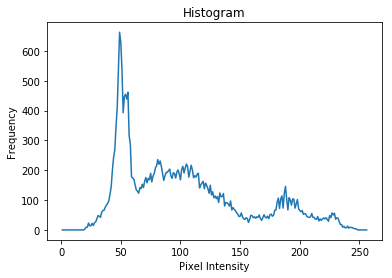

In [11]:
# plotting the histogram manually
plt.figure() # use the figure() commmand to create a NEW figure
plt.plot(n[1][1:],n[0]) # note the size difference
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram')

For efficiency, we can compute the **normalized** histogram:

Text(0.5, 1.0, 'Probability Density Function')

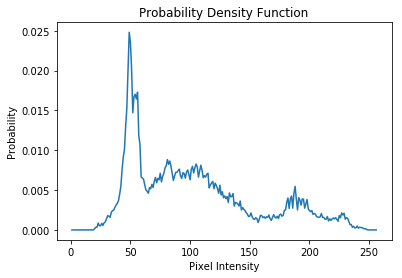

In [12]:
p = 1.0/np.sum(n[0]) * n[0]
# bw_histogram_normalized = 1.0/(bw_histogram[0].sum()) * bw_histogram[0]
plt.figure()
plt.plot(n[1][1:], p)
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability')
plt.title('Probability Density Function')

# How is this plot different from the previous one?

We can also compute the cumulative distribution function:

Text(0.5, 1.0, 'Cumulative Density Function')

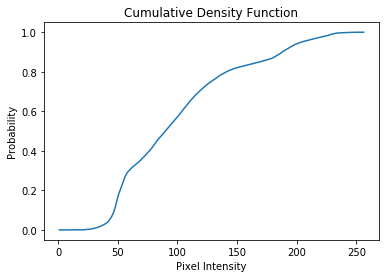

In [13]:
CDF = np.zeros( len( p ) )
CDF[0] = p[0]
for i in range(1, len(p )):
    CDF[i] = CDF[i-1] + p[i]
        
plt.figure()
plt.plot(n[1][1:], CDF )
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability')
plt.title('Cumulative Density Function')

Hence, we can define the following variables:

In [16]:
w_0 = CDF
w_1 = 1-w_0

And the class mean:

$\mu_0 = \sum_{i=0}^{t-1} i \frac{p_i}{\omega_0} = \frac{\mu(k)}{\omega(k)}$


$\mu_1 = \sum_{i=t}^{L-1} i \frac{p_i}{\omega_1} = \frac{\mu_T - \mu(k)}{1-\omega(k)}$

and the class variances are given by:

$\sigma^2_0 = \sum_{i=1}^{t} (i-\mu_0)^2 \frac{p_i}{\omega_0}$

$\sigma^2_1 = \sum_{i=t+1}^{L} (i-\mu_1)^2 \frac{p_i}{\omega_1}$

#### Take a close look at these definitions.  What happens when the histogram bin is $0$?

As it turns out, the intra-class variance:


$\sigma^2_{w}(t) = \omega_{0}(t) \sigma^2_{0}(t) + \omega_{1}(t) \sigma_{1}^{2}(t)$

is **not** the only functional we can optimize.  Refer to the [original paper by Otsu](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4310076): Equation (12) to (10) states that, the minimization of the intra-class variance is the same as maximization of the inter-class variance $\sigma_b^2$:

$\sigma^2_b(t) = \frac{[\mu_T \omega(t) - \mu(t)]^2}{\omega_0(k) (1-\omega_0(k)) }$

Which can be easily implemented. Note that the numerator is always **positive**. Hence, if the $\omega_0{k} == 0$ or $\omega_1{k}==0$, we can simply set $\sigma_b^2(t)$ to $0$ instead.

In [17]:
# P is the normalized histogram

levels = np.zeros([256])
w = np.zeros([256])     # 0th-order cumulative moment, or CDF, we computed it earlier but repeating it for completeness
mu = np.zeros([256])    # 1st-order cumulative moment, or the class mean
w[0] = p[0]
mu[0] = 0

# preparation
for t in range(1,256):    # for each threshold value t, compute the 0th and 1st moment
    w[t] = w[t-1] + p[t]
    mu[t] = mu[t-1] + t * p[t]
mu_T = mu[255]            # the total mean pixel intensity of the original image


# exhustive search
for t in range(0,256):
    if ( w[t]*(1-w[t]) > 0 ): # avoid division by 0
        levels[t] = ((mu_T * w[t] - mu[t])*(mu_T * w[t] - mu[t])) /(w[t]*(1-w[t]))

122


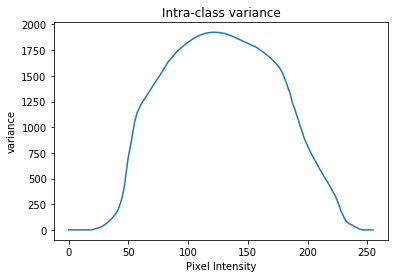

In [18]:
plt.figure()
plt.plot(range(0,256), levels)
plt.xlabel('Pixel Intensity')
plt.ylabel('variance')
plt.title('Intra-class variance')
print(np.argmax(levels))

Let s verify our implementation against SimpleITK's implementation

In [19]:
img_255 = sitk.Cast(sitk.RescaleIntensity(img_bw), sitk.sitkUInt8)
otsu_filter = sitk.OtsuThresholdImageFilter()
inside_value = 1
outside_value = 0
otsu_filter.SetInsideValue(inside_value)
otsu_filter.SetOutsideValue(outside_value)
seg = otsu_filter.Execute(img_bw)
sitk.Show(sitk.LabelOverlay(img_255, seg), title='Segmented Image') # the image is too large to use myshow
print( otsu_filter.GetThreshold())

121.74834252929688


### Alternative (more efficient) implementation

As it turned out, we needed 2 for-loops for our computation. It is conceptually clean but slightly inefficient.  Specifically, we needed the 1st for-loop to compute the total mean leavel of the original image. 

**as a side note**, here is an alternative implementation that requires only 1 for-loop.

In [21]:
histogramCounts = n[0]
levels = np.zeros([256])
N = histogramCounts.sum()
sumB = 0
wB = 0
maximum = 0.0
sum1 = np.sum( range(0,256) * histogramCounts )
level = 0
for ii in range(0,256):
    wB = wB + histogramCounts[ii]
    wF = N - wB
    if ( wB !=0 and wF != 0):
        sumB = sumB + ii * histogramCounts[ii]
        mF = ( sum1 - sumB ) / wF
        between = wB * wF * (( sumB / wB ) - mF ) * ((sumB/wB) - mF)
        levels[ii] = between
        if ( between >= maximum ):
            level = ii
            maximum = between
print(level)

122


122


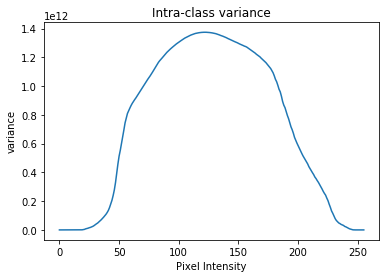

In [22]:
plt.figure()
plt.plot(range(0,256), levels)
plt.xlabel('Pixel Intensity')
plt.ylabel('variance')
plt.title('Intra-class variance')
print(np.argmax(levels))